# Descripción del data set Financial data of 4400+ public companies

✅ ¿Qué es?

Se trata de un conjunto de datos que contiene información financiera de más de 4 400 empresas públicas.  

Los datos fueron raspados (“scraped”) de Yahoo Finance, lo que incluye los estados financieros — el balance general (“balance sheet”), el estado de resultados (“income statement”), y el flujo de caja (“cash flow statement”).  

Incluye datos tanto anuales como trimestrales para un período reciente (aproximadamente los últimos 4 años) para cada empresa.  


# ¿Qué contiene exactamente?

Algunas de las características clave de la base de datos:

- Cada empresa viene identificada con su ticker o símbolo bursátil (o equivalente) y posiblemente con su nombre, industria, etc.
- Para cada empresa, los datos incluyen:
    - Estado de resultados: ingresos, beneficios, gastos, etc.
    - Balance general: activos, pasivos, capital contable, etc.
    - Flujo de caja: flujos operativos, de inversión, de financiación, etc.
- Los datos están organizados para que puedas ver la evolución por trimestre y por año, lo que permite análisis de tendencias.
- Se pueden usar variables financieras como predictors (por ejemplo: activos, pasivos, ingresos) y variables objetivo como beneficio, rentabilidad, crecimiento, etc.

# Paso 1 — Reconocer el dataset

1. Objetivo: investigar el dataset entregado en la asignación 2, revisar el nombre de cada columna y documentar qué representa cada una (tipo, unidad, periodicidad, observaciones).

2. Pasos recomendados:
    - Cargar el archivo entregado (por ejemplo: df = pd.read_csv(...)) y listar columnas: df.columns
    - Para cada columna: buscar su significado (glosario, documentación de la fuente, o inspección de valores).
    - Anotar tipo de dato, unidad (USD, porcentaje, entero), periodicidad (trimestral/anual) y cualquier observación (por ejemplo: calculada, acumulada, neta/bruta).
    - Generar la lista final con nombre y descripción clara y breve.

3. Ejemplo de Plantilla para la lista (reemplazar con las columnas reales del dataset):

- ticker: Identificador bursátil de la empresa (string). Ejemplo: "AAPL".
- fiscal_date: Fecha del periodo financiero (YYYY-MM-DD). Indica el cierre del trimestre/año.
- revenue: Ingresos netos durante el periodo (num, USD). Periodicidad: trimestral/anual.
- gross_profit: Beneficio bruto (num, USD). Definición: ingresos menos costo de ventas.
- operating_income: Resultado operativo (num, USD). Incluye gastos operativos.
- net_income: Beneficio neto después de impuestos (num, USD).


4. Resultado esperado:
    - Un listado documentado con cada columna del dataset y su descripción (puede entregarse como tabla o como lista de pares nombre→descripción).

In [1]:
import os
import glob
import pandas as pd
import numpy as np

# Paso 1 — Cargar el CSV y generar una plantilla de documentación de columnas
# Resultado: imprime info básica del dataframe y crea `column_documentation.csv`
# Ajusta `csv_file` manualmente si quieres elegir otro archivo cuando haya varios .csv.


# Buscar archivos .csv en el directorio actual
csv_files = glob.glob("*.csv")
if not csv_files:
    # buscar recursivamente si no hay en el directorio raíz
    csv_files = [p for p in glob.glob("**/*.csv", recursive=True)]
if not csv_files:
    raise FileNotFoundError("No se encontró ningún archivo .csv en el directorio actual ni subdirectorios.")

print("Archivos .csv encontrados:")
for i, f in enumerate(csv_files):
    print(f"  [{i}] {f}")

# Por defecto tomar el primero; si hay varios, puedes asignar csv_file = csv_files[ÍNDICE] manualmente
csv_file = csv_files[0]
print(f"\nUsando archivo: {csv_file}\n")

# Cargar el csv (usar low_memory=False para evitar warnings de tipos)
df = pd.read_csv(csv_file, low_memory=False)

# Resumen rápido
print("Dimensiones del dataframe:", df.shape)
print("\nColumnas:")
print(df.columns.tolist())

print("\nPrimeras 3 filas:")
display(df.head(3))

print("\nTipos de datos y valores nulos por columna:")
info_df = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null_count": df.notna().sum().astype(int),
    "null_count": df.isna().sum().astype(int),
    "unique_count": df.nunique(dropna=True).astype(int)
})
display(info_df)

# Construir plantilla de documentación con heurísticas básicas
def infer_props(col, series):
    name = col
    lname = name.lower()
    props = {"name": name, "inferred_type": str(series.dtype), "non_null": int(series.notna().sum()),
             "nulls": int(series.isna().sum()), "n_unique": int(series.nunique(dropna=True))}
    # sample values
    try:
        samples = list(pd.unique(series.dropna())[:5])
        props["sample_values"] = samples
    except Exception:
        props["sample_values"] = []
    # heurística para rol / unidad / periodicidad
    role = "otro"
    unit = ""
    suggested_dtype = ""
    periodicity = "desconocida"
    notes = []

    if any(k in lname for k in ["date", "fecha", "period_end", "period", "enddate", "fiscal"]):
        role = "fecha"
        suggested_dtype = "datetime"
        notes.append("convertir con pd.to_datetime")
        # intentar inferir periodicidad por diferencias entre fechas (si son datetimes)
        try:
            ser_dt = pd.to_datetime(series.dropna().iloc[:50], errors='coerce')
            if ser_dt.notna().sum() > 3:
                diffs = ser_dt.sort_values().diff().dropna().dt.days
                median_days = diffs.median()
                if pd.notna(median_days):
                    if median_days <= 95:
                        periodicity = "trimestral/aprox"
                    elif median_days >= 360:
                        periodicity = "anual/aprox"
        except Exception:
            pass

    elif any(k in lname for k in ["ticker", "stock", "symbol", "isin", "cik"]):
        role = "identificador_empresa"
        suggested_dtype = "string"
        periodicity = "por empresa"
    elif any(k in lname for k in ["cash", "cashflow", "cash_flow", "cash_and", "cashand"]):
        role = "cash"
        unit = "moneda (prob. USD)"
        suggested_dtype = "numeric"
        notes.append("limpiar símbolos monetarios y convertir a float")
    elif any(k in lname for k in ["revenue", "income", "sales", "net_revenue", "totalrevenue", "profit", "ebit"]):
        role = "income/revenue"
        unit = "moneda (prob. USD)"
        suggested_dtype = "numeric"
    elif any(k in lname for k in ["asset", "liabil", "equity", "debt", "balance"]):
        role = "balance"
        unit = "moneda (prob. USD)"
        suggested_dtype = "numeric"
    elif any(k in lname for k in ["percent", "%", "ratio", "margin", "growth"]):
        role = "porcentaje/ratio"
        unit = "porcentaje"
        suggested_dtype = "numeric"
    elif any(k in lname for k in ["year", "quarter", "qtr", "fyear"]):
        role = "periodo"
        suggested_dtype = "int/string"
    else:
        # si la columna es numérica y tiene muchos valores repetidos, sugerir categoría o id
        if pd.api.types.is_integer_dtype(series.dtype) and series.nunique() < 50:
            role = "posible_categoria/indice"
        elif pd.api.types.is_float_dtype(series.dtype):
            role = "numérico"

    props.update({
        "role_guess": role,
        "unit_guess": unit,
        "periodicity_guess": periodicity,
        "suggested_dtype": suggested_dtype,
        "notes": "; ".join(notes) if notes else ""
    })
    return props

rows = []
for col in df.columns:
    rows.append(infer_props(col, df[col]))

doc_df = pd.DataFrame(rows).set_index("name")
# Columnas útiles para revisar y editar manualmente
cols_order = ["inferred_type", "role_guess", "unit_guess", "periodicity_guess", "non_null", "nulls", "n_unique", "sample_values", "suggested_dtype", "notes"]
doc_df = doc_df[cols_order]

print("\nPlantilla de documentación de columnas (revisar y completar manualmente):")
display(doc_df)

# Guardar plantilla para que la completes manualmente
out_file = "column_documentation.csv"
doc_df.to_csv(out_file, index=True)
print(f"\nSe guardó una copia editable en: {out_file}")
print("Siguientes pasos recomendados:")
print("- Revisar la columna 'role_guess' y completar/describir cada columna (tipo, unidad, periodicidad, observaciones).")
print("- Si es necesario, convertir columnas: fechas → pd.to_datetime, monetarias → float tras limpiar símbolos, categóricas → str/astype('category').")

Archivos .csv encontrados:
  [0] balanceSheetHistory_annually.csv

Usando archivo: balanceSheetHistory_annually.csv

Dimensiones del dataframe: (17511, 31)

Columnas:
['stock', 'endDate', 'accountsPayable', 'inventory', 'longTermDebt', 'netReceivables', 'netTangibleAssets', 'longTermInvestments', 'totalCurrentAssets', 'propertyPlantEquipment', 'otherStockholderEquity', 'deferredLongTermAssetCharges', 'totalCurrentLiabilities', 'cash', 'otherAssets', 'treasuryStock', 'goodWill', 'otherLiab', 'retainedEarnings', 'otherCurrentAssets', 'commonStock', 'totalAssets', 'otherCurrentLiab', 'deferredLongTermLiab', 'totalStockholderEquity', 'totalLiab', 'capitalSurplus', 'intangibleAssets', 'shortTermInvestments', 'shortLongTermDebt', 'minorityInterest']

Primeras 3 filas:


,stock,endDate,accountsPayable,inventory,longTermDebt,netReceivables,netTangibleAssets,longTermInvestments,totalCurrentAssets,propertyPlantEquipment,...,totalAssets,otherCurrentLiab,deferredLongTermLiab,totalStockholderEquity,totalLiab,capitalSurplus,intangibleAssets,shortTermInvestments,shortLongTermDebt,minorityInterest
0,IVC,2019-12-31,88003000.0,121184000.0,219464000.0,140013000.0,-91334000.0,85000.0,355877000.0,92183000.0,...,8.521260e+08,21634000.0,602000.0,308516000.0,543610000.0,312650000.0,26447000.0,NaN,NaN,NaN
1,IVC,2018-12-31,92469000.0,128644000.0,225733000.0,138476000.0,-48632000.0,90000.0,397410000.0,74306000.0,...,8.858550e+08,22750000.0,402000.0,359147000.0,526708000.0,297919000.0,26506000.0,NaN,NaN,NaN
2,IVC,2017-12-31,90566000.0,121933000.0,241405000.0,143464000.0,-8233000.0,103000.0,456914000.0,80016000.0,...,1.066033e+09,34119000.0,787000.0,423294000.0,642739000.0,290125000.0,30244000.0,NaN,NaN,NaN



Tipos de datos y valores nulos por columna:


,dtype,non_null_count,null_count,unique_count
stock,object,17511,0,4422
endDate,object,17511,0,255
accountsPayable,float64,16415,1096,14819
inventory,float64,9640,7871,8867
longTermDebt,float64,11222,6289,10746
netReceivables,float64,14544,2967,13691
netTangibleAssets,float64,17351,160,17089
longTermInvestments,float64,7499,10012,6874
totalCurrentAssets,float64,17331,180,16999
propertyPlantEquipment,float64,15768,1743,14905



Plantilla de documentación de columnas (revisar y completar manualmente):


,inferred_type,role_guess,unit_guess,periodicity_guess,non_null,nulls,n_unique,sample_values,suggested_dtype,notes
name,,,,,,,,,,
stock,object,identificador_empresa,,por empresa,17511,0,4422,"[IVC, CSLT, LPX, GDYN, ARA]",string,
endDate,object,fecha,,trimestral/aprox,17511,0,255,"[2019-12-31, 2018-12-31, 2017-12-31, 2016-12-3...",datetime,convertir con pd.to_datetime
accountsPayable,float64,numérico,,desconocida,16415,1096,14819,"[88003000.0, 92469000.0, 90566000.0, 88236000....",,
inventory,float64,numérico,,desconocida,9640,7871,8867,"[121184000.0, 128644000.0, 121933000.0, 135644...",,
longTermDebt,float64,balance,moneda (prob. USD),desconocida,11222,6289,10746,"[219464000.0, 225733000.0, 241405000.0, 146088...",numeric,
netReceivables,float64,numérico,,desconocida,14544,2967,13691,"[140013000.0, 138476000.0, 143464000.0, 132707...",,
netTangibleAssets,float64,balance,moneda (prob. USD),desconocida,17351,160,17089,"[-91334000.0, -48632000.0, -8233000.0, 3276200...",numeric,
longTermInvestments,float64,numérico,,desconocida,7499,10012,6874,"[85000.0, 90000.0, 103000.0, 108000.0, 1000000...",,
totalCurrentAssets,float64,balance,moneda (prob. USD),desconocida,17331,180,16999,"[355877000.0, 397410000.0, 456914000.0, 409072...",numeric,



Se guardó una copia editable en: column_documentation.csv
Siguientes pasos recomendados:
- Revisar la columna 'role_guess' y completar/describir cada columna (tipo, unidad, periodicidad, observaciones).
- Si es necesario, convertir columnas: fechas → pd.to_datetime, monetarias → float tras limpiar símbolos, categóricas → str/astype('category').


# Paso 2 — Seleccionar columnas relevantes

Después de haber cargado el dataset, elimina todas las columnas y quédate solo con: `stock`, `endDate` y `cash`.

- Verifica que los nombres y la capitalización de las columnas sean correctos antes de seleccionar.


In [2]:
# Paso 2 — Seleccionar solo las columnas `stock`, `endDate` y `cash`
required = ['stock', 'endDate', 'cash']
available = df.columns.tolist()

# Verificar existencia exacta; si faltan, intentar coincidencia case-insensitive y renombrar
missing = [c for c in required if c not in df.columns]
if missing:
    lower_map = {c.lower(): c for c in df.columns}
    renamed = {}
    for req in missing:
        key = req.lower()
        if key in lower_map:
            renamed[lower_map[key]] = req
    if renamed:
        df = df.rename(columns=renamed)
        print("Se renombraron columnas para coincidir con los nombres requeridos:", renamed)
    missing = [c for c in required if c not in df.columns]

if missing:
    raise KeyError(f"No se encontraron las columnas requeridas: {missing}. Columnas disponibles: {available}")

# Mantener solo las columnas requeridas (hacer copy para evitar SettingWithCopyWarning)
df = df[required].copy()

# Convertir endDate a datetime y reportar resultados
df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')
print("Dimensiones tras seleccionar columnas:", df.shape)
print("\nTipos y valores nulos:")
display(pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "nulls": df.isna().sum()
}))
print("\nPrimeras filas:")
display(df.head())

Dimensiones tras seleccionar columnas: (17511, 3)

Tipos y valores nulos:


,dtype,non_null,nulls
stock,object,17511,0
endDate,datetime64[ns],17511,0
cash,float64,16929,582



Primeras filas:


,stock,endDate,cash
0,IVC,2019-12-31,80063000.0
1,IVC,2018-12-31,116907000.0
2,IVC,2017-12-31,176528000.0
3,IVC,2016-12-31,124234000.0
4,CSLT,2019-12-31,43017000.0


# Paso 3 — Separar por empresas y elegir 3 para predecir su cantidad de dinero por fecha

- Objetivo: crear series temporales por empresa usando las columnas `stock`, `endDate` y `cash` y seleccionar 3 empresas para modelar y predecir `cash` por fecha.
- Pasos recomendados:
    - Verificar que las columnas `stock`, `endDate` y `cash` existen y están limpias (sin valores nulos o con imputación cuando sea necesario).
    - Ordenar el dataframe por `stock` y `endDate` (ascendente) para obtener la serie temporal de cada empresa.
    - Agrupar por `stock` y crear un subset por empresa.
    - Elegir 3 empresas con suficientes observaciones (p. ej. mayor número de fechas disponibles o relevancia del negocio).
    - Para cada empresa seleccionada, preparar los datos de entrenamiento/validación (features temporales, ventanas, lag, etc.) y definir la variable objetivo `cash` por `endDate`.

In [3]:
# Paso 3 — Separar por empresas y elegir 3 para predecir `cash` por fecha

# 1) Verificar columnas y tipos básicos
print("Columnas disponibles:", df.columns.tolist())
print("\nTipos:\n", df.dtypes)
print("\nValores nulos por columna:\n", df.isna().sum())

# Asegurar endDate como datetime (idempotente)
df['endDate'] = pd.to_datetime(df['endDate'], errors='coerce')

# 2) Estadísticas por empresa: total filas y filas con cash no nulo
grp = df.groupby('stock').agg(
    total_rows = ('endDate', 'size'),
    unique_dates = ('endDate', lambda s: s.nunique()),
    non_null_cash = ('cash', lambda s: s.notna().sum())
).sort_values(['non_null_cash','unique_dates','total_rows'], ascending=False)

print("\nResumen por empresa (top 10 por observaciones con cash):")
display(grp.head(10))

# 3) Seleccionar 3 empresas con suficientes observaciones de `cash`
MIN_OBS = 4  # mínimo de observaciones con cash (ajustable)
candidates = grp[grp['non_null_cash'] >= MIN_OBS].index.tolist()

if len(candidates) < 3:
    # fallback: tomar las 3 con más observaciones (aunque estén por debajo del mínimo)
    stocks_selected = grp.index[:3].tolist()
    print(f"\nNo hay >= {MIN_OBS} empresas con suficientes observaciones. Seleccionando top 3 por ocurrencias: {stocks_selected}")
else:
    stocks_selected = candidates[:3]
    print(f"\nEmpresas seleccionadas (>= {MIN_OBS} observaciones con cash): {stocks_selected}")

# 4) Crear un dict con los dataframes ordenados por fecha para cada empresa seleccionada
stock_dfs = {}
for s in stocks_selected:
    sub = df[df['stock'] == s].sort_values('endDate').reset_index(drop=True)
    # conservar ambas versiones: completa y sólo con cash no nulo (para modelado)
    stock_dfs[s] = {
        'full': sub,
        'with_cash': sub[sub['cash'].notna()].reset_index(drop=True)
    }
    print(f"\n{s}: filas totales = {len(sub)}, filas con cash = {len(stock_dfs[s]['with_cash'])}")
    display(stock_dfs[s]['with_cash'].head())

# Resultado: stocks_selected (lista), stock_dfs (dict con dataframes preparados)
print("\nPaso 3 completado. Usar `stocks_selected` y `stock_dfs` para los siguientes pasos (gráficas y modelado).")

Columnas disponibles: ['stock', 'endDate', 'cash']

Tipos:
 stock              object
endDate    datetime64[ns]
cash              float64
dtype: object

Valores nulos por columna:
 stock        0
endDate      0
cash       582
dtype: int64

Resumen por empresa (top 10 por observaciones con cash):


,total_rows,unique_dates,non_null_cash
stock,,,
A,4,4,4
AA,4,4,4
AAL,4,4,4
AAME,4,4,4
AAN,4,4,4
AAOI,4,4,4
AAON,4,4,4
AAP,4,4,4
AAPL,4,4,4



Empresas seleccionadas (>= 4 observaciones con cash): ['A', 'AA', 'AAL']

A: filas totales = 4, filas con cash = 4


,stock,endDate,cash
0,A,2016-10-31,2.289000e+09
1,A,2017-10-31,2.678000e+09
2,A,2018-10-31,2.247000e+09
3,A,2019-10-31,1.382000e+09



AA: filas totales = 4, filas con cash = 4


,stock,endDate,cash
0,AA,2016-12-31,8.530000e+08
1,AA,2017-12-31,1.358000e+09
2,AA,2018-12-31,1.113000e+09
3,AA,2019-12-31,8.790000e+08



AAL: filas totales = 4, filas con cash = 4


,stock,endDate,cash
0,AAL,2016-12-31,322000000.0
1,AAL,2017-12-31,295000000.0
2,AAL,2018-12-31,275000000.0
3,AAL,2019-12-31,280000000.0



Paso 3 completado. Usar `stocks_selected` y `stock_dfs` para los siguientes pasos (gráficas y modelado).


# Paso 4 — Grafique tiempo vs dinero de las 3 empresas en 3 gráficas diferentes

Objetivo: visualizar la serie temporal de `cash` frente a `endDate` para cada una de las 3 empresas seleccionadas, colocando cada empresa en una gráfica independiente.

Pasos recomendados:
- Asegurarse de tener el DataFrame con las columnas `stock`, `endDate` y `cash` y ordenado por `stock` y `endDate` ascendente.
- Convertir `endDate` a tipo fecha: `df['endDate'] = pd.to_datetime(df['endDate'])`.
- Seleccionar las 3 empresas elegidas: p. ej. `stocks = ['AAA','BBB','CCC']` y crear un subset por cada `stock`.
- Para cada empresa, graficar `endDate` en el eje x y `cash` en el eje y en una figura separada.
- Configurar títulos, etiquetas de ejes y formato de fechas (rotar etiquetas si es necesario). Añadir grid y leyenda si procede.
- Opcional: usar subplots (3 filas x 1 columna) para mostrar las 3 gráficas en la misma figura o generar 3 figuras individuales según preferencia.
- Guardar las figuras si es necesario: `plt.savefig('cash_stock_AAA.png', bbox_inches='tight')`.

Ejemplo de librerías a usar: matplotlib, seaborn o plotly para interactividad.

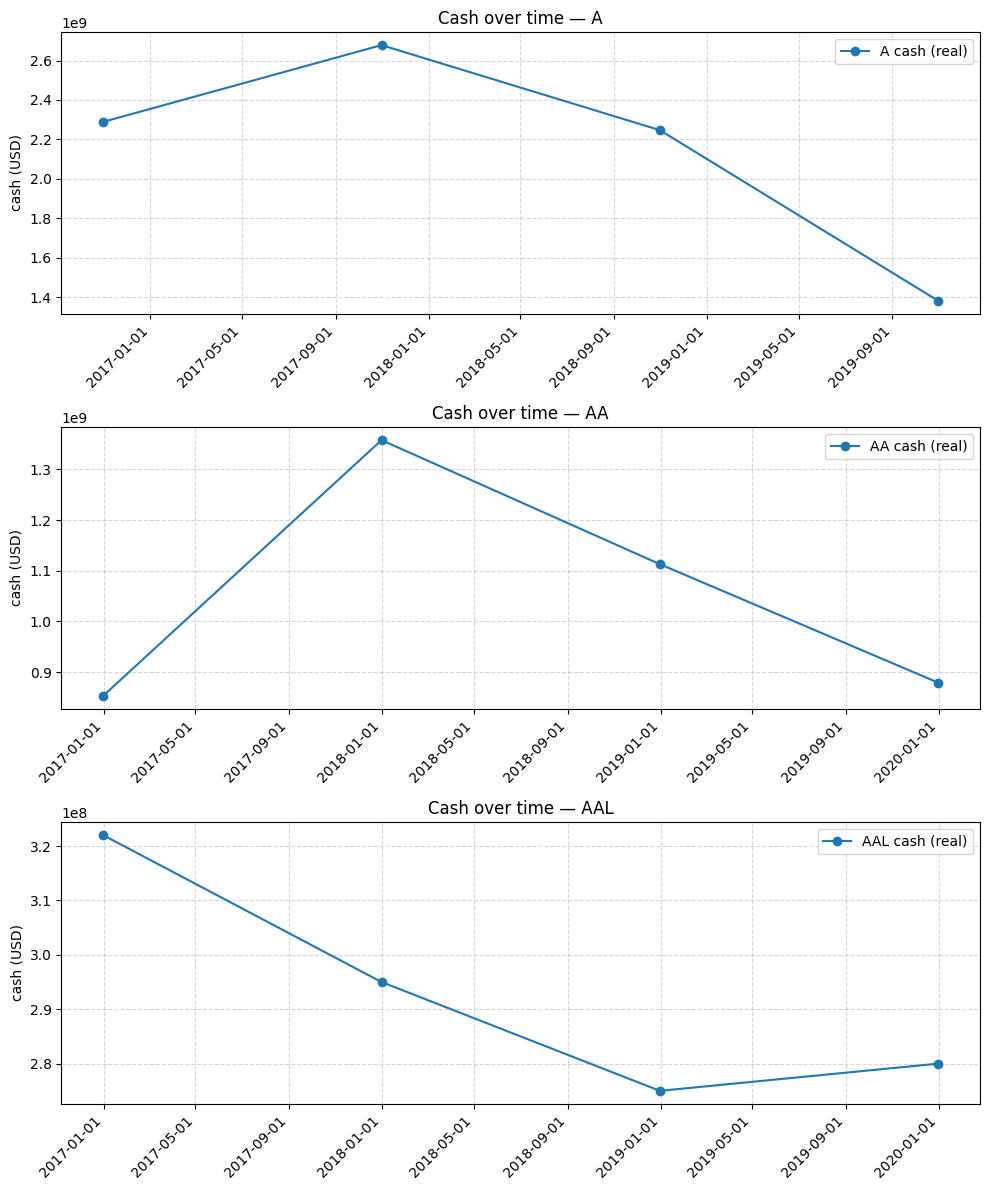

In [6]:
#%pip install matplotlib

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Graficar cash vs endDate para las 3 empresas seleccionadas (cada una en su propia figura/subplot)
stocks = stocks_selected  # usa la lista ya definida en celdas anteriores

fig, axes = plt.subplots(len(stocks), 1, figsize=(10, 4 * len(stocks)))
if len(stocks) == 1:
    axes = [axes]

for ax, s in zip(axes, stocks):
    df_s = stock_dfs[s]['with_cash'].sort_values('endDate').reset_index(drop=True)
    ax.plot(df_s['endDate'], df_s['cash'], marker='o', linestyle='-', label=f'{s} cash (real)')
    ax.set_title(f'Cash over time — {s}')
    ax.set_ylabel('cash (USD)')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

    # Formato de fechas en el eje x
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

plt.tight_layout()
plt.show()

# Paso 5 — División 80/20 (entrenamiento / prueba)

Objetivo: separar los datos en 80% para entrenamiento y 20% para prueba respetando la estructura temporal por empresa (sin hacer shuffle).

Recomendaciones:
- Asegúrate de tener las columnas `stock`, `endDate` y `cash` y que el dataframe esté ordenado por `stock` y `endDate` (ascendente).
- Para series temporales por empresa, usa una división basada en tiempo: los primeros 80% de observaciones de cada `stock` → train; los últimos 20% → test.



In [7]:
# Paso 5 — División 80/20 (entrenamiento / prueba) por empresa (sin shuffle)
# Usa las variables ya definidas: stocks_selected, stock_dfs, MIN_OBS, pd, np

splits = {}  # almacenará train/test por ticker

for s in stocks_selected:
    df_s = stock_dfs[s]['with_cash'].sort_values('endDate').reset_index(drop=True)
    n = len(df_s)
    if n == 0:
        print(f"{s}: no hay filas con `cash`. Se omite.")
        continue

    # tamaño de test = ceil(20% de n), al menos 1
    test_size = max(1, int(np.ceil(0.2 * n)))
    split_idx = n - test_size

    # asegurar que haya al menos una fila en train (si no, ajustar)
    if split_idx < 1:
        split_idx = max(1, n - 1)
        test_size = n - split_idx

    train = df_s.iloc[:split_idx].copy()
    test = df_s.iloc[split_idx:].copy()

    # mantener endDate como datetime y orden correcto (idempotente)
    train['endDate'] = pd.to_datetime(train['endDate'], errors='coerce')
    test['endDate'] = pd.to_datetime(test['endDate'], errors='coerce')

    splits[s] = {'train': train, 'test': test}

    # Resumen rápido
    print(f"{s}: total={n}, train={len(train)}, test={len(test)} | "
          f"train fechas: {train['endDate'].min().date() if len(train) else 'NA'} → {train['endDate'].max().date() if len(train) else 'NA'} | "
          f"test fechas: {test['endDate'].min().date() if len(test) else 'NA'} → {test['endDate'].max().date() if len(test) else 'NA'}")

# Resultado disponible en `splits` como:
# splits['TICKER']['train']  -> dataframe de entrenamiento
# splits['TICKER']['test']   -> dataframe de prueba

# Mostrar ejemplo (primeras filas) para las 3 empresas seleccionadas
for s in stocks_selected:
    if s in splits:
        print(f"\n--- {s} TRAIN head ---")
        display(splits[s]['train'].head())
        print(f"--- {s} TEST head ---")
        display(splits[s]['test'].head())

A: total=4, train=3, test=1 | train fechas: 2016-10-31 → 2018-10-31 | test fechas: 2019-10-31 → 2019-10-31
AA: total=4, train=3, test=1 | train fechas: 2016-12-31 → 2018-12-31 | test fechas: 2019-12-31 → 2019-12-31
AAL: total=4, train=3, test=1 | train fechas: 2016-12-31 → 2018-12-31 | test fechas: 2019-12-31 → 2019-12-31

--- A TRAIN head ---


,stock,endDate,cash
0,A,2016-10-31,2.289000e+09
1,A,2017-10-31,2.678000e+09
2,A,2018-10-31,2.247000e+09


--- A TEST head ---


,stock,endDate,cash
3,A,2019-10-31,1.382000e+09



--- AA TRAIN head ---


,stock,endDate,cash
0,AA,2016-12-31,8.530000e+08
1,AA,2017-12-31,1.358000e+09
2,AA,2018-12-31,1.113000e+09


--- AA TEST head ---


,stock,endDate,cash
3,AA,2019-12-31,879000000.0



--- AAL TRAIN head ---


,stock,endDate,cash
0,AAL,2016-12-31,322000000.0
1,AAL,2017-12-31,295000000.0
2,AAL,2018-12-31,275000000.0


--- AAL TEST head ---


,stock,endDate,cash
3,AAL,2019-12-31,280000000.0


# Paso 6 — crea y entrena el modelo de regresión lineal para predecir `cash` por empresa

Objetivo: entrenar un modelo de regresión lineal por cada `stock` usando la serie temporal (respetando orden temporal) y evaluar en el 20% final.

Pasos recomendados:
- Preprocesamiento
    - Definir variables para el entrenamiento: y = `cash` (variable objetivo). `data` → X (conjunto de características a usar para predecir `cash`, p. ej. rezagos de `cash`, indicadores temporales, variables exógenas). Usar X e y en el entrenamiento: `model.fit(X_train, y_train)`.
    - Asegurar `endDate` como datetime y ordenar por `stock`, `endDate`.  - Asegurar `endDate` como datetime y ordenar por `stock`, `endDate`.



In [8]:
from sklearn.linear_model import LinearRegression

# Paso 6 — crear y entrenar un modelo de regresión lineal por empresa (usar rezago y año como features)

models = {}
for s in stocks_selected:
    df_s = stock_dfs[s]['with_cash'].sort_values('endDate').reset_index(drop=True)
    n = len(df_s)
    if n == 0:
        print(f"{s}: sin datos con `cash`, se omite.")
        continue

    # tamaño de test ya calculado en `splits`
    test_size = len(splits[s]['test'])
    split_idx = n - test_size

    # crear features simples: lag1, lag2 y year
    df_feat = df_s.copy()
    df_feat['lag1'] = df_feat['cash'].shift(1)
    df_feat['lag2'] = df_feat['cash'].shift(2)
    df_feat['year'] = df_feat['endDate'].dt.year

    # definir train/test por posición temporal (sin shuffle)
    train_feat = df_feat.iloc[:split_idx].copy()
    test_feat = df_feat.iloc[split_idx:].copy()

    # requerir al menos lag1 para entrenar/predicción (lag1 toma valor de la fila anterior)
    train_feat = train_feat.dropna(subset=['lag1'])
    test_feat = test_feat.dropna(subset=['lag1'])

    # preparar X/y (usar lag1 y year para evitar demasiados NaN en samples pequeños)
    feature_cols = ['lag1', 'year']

    if len(train_feat) < 1:
        # fallback: baseline simple (media del train disponible o global)
        baseline_mean = df_s['cash'].iloc[:split_idx].mean() if split_idx > 0 else df_s['cash'].mean()
        y_pred = np.repeat(baseline_mean, len(test_feat))
        preds_df = test_feat[['endDate', 'cash']].copy().reset_index(drop=True)
        preds_df['y_pred'] = y_pred
        models[s] = {'model': None, 'type': 'baseline_mean', 'baseline': baseline_mean}
        print(f"{s}: no hay suficientes filas para entrenar (después de crear lag). Usando baseline mean → {baseline_mean:.2f}")
    else:
        X_train = train_feat[feature_cols].values
        y_train = train_feat['cash'].values
        X_test = test_feat[feature_cols].values
        y_test = test_feat['cash'].values

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        preds_df = test_feat[['endDate', 'cash']].copy().reset_index(drop=True)
        preds_df['y_pred'] = y_pred

        models[s] = {'model': model, 'type': 'linear_regression', 'features': feature_cols}

        print(f"{s}: modelo lineal entrenado | train_rows={len(train_feat)} | test_rows={len(test_feat)}")

    # guardar predicciones y datos para pasos siguientes (Paso 7/8)
    splits[s]['preds'] = preds_df
    splits[s]['model_info'] = models[s]

print("\nEntrenamiento completado. Los objetos `models` y `splits[<TICKER>]['preds']` están disponibles para evaluar y graficar.")

A: modelo lineal entrenado | train_rows=2 | test_rows=1
AA: modelo lineal entrenado | train_rows=2 | test_rows=1
AAL: modelo lineal entrenado | train_rows=2 | test_rows=1

Entrenamiento completado. Los objetos `models` y `splits[<TICKER>]['preds']` están disponibles para evaluar y graficar.


# Paso 7 — Verifica tu modelo de regresión lineal: grafica real vs predicho para las 3 empresas

- Objetivo: comparar visualmente los valores reales de `cash` del conjunto de prueba con los valores predichos por el modelo para cada una de las 3 empresas seleccionadas.
- Requisitos: tener `endDate` como datetime, el conjunto test por cada `stock`, y las predicciones (`y_pred`) para cada test.
- Pasos recomendados:
    - Para cada empresa (stock):
        - Extraer test: filas finales (20%) ordenadas por `endDate`.
        - Obtener predicciones usando el modelo entrenado: `y_pred = model.predict(X_test)`.
        - Crear una gráfica con `endDate` en el eje x y ambos: `cash` real (línea/points) y `cash` predicho (línea punteada) en el eje y.
        - Añadir título con el ticker, leyenda, etiquetas de ejes y grid. Formatear fechas y rotar etiquetas si hace falta.
    - Opcional: mostrar las 3 series en subplots (3 filas x 1 columna) para facilitar comparación.
    - Calcular y mostrar métricas de error por empresa (MAE, RMSE, R2) bajo cada gráfico o en una tabla resumen.
- Resultado esperado: tres gráficas (una por empresa) mostrando real vs predicho y una tabla o texto con las métricas de evaluación.

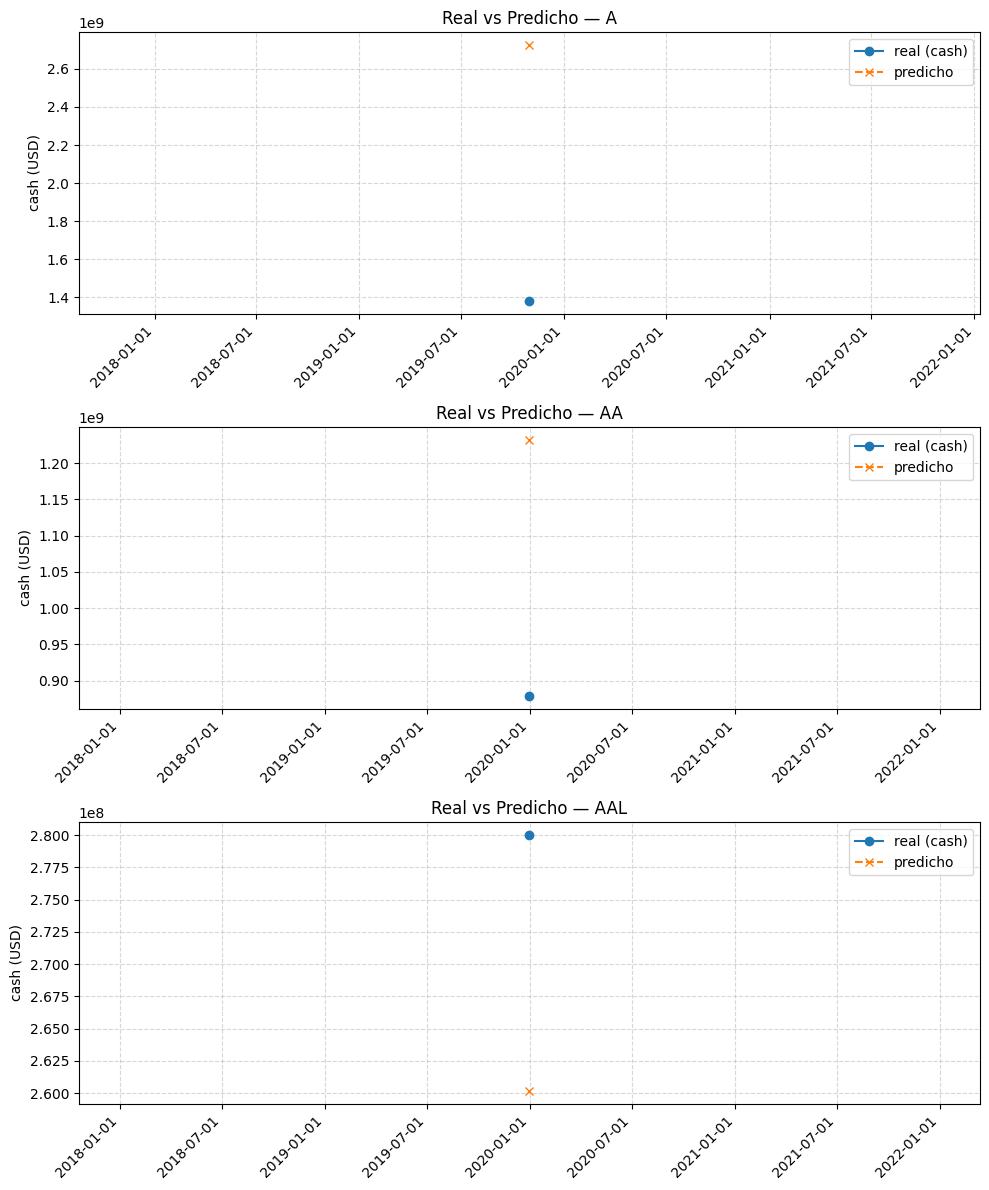

,n_test,MAE,MSE,RMSE,R2
stock,,,,,
A,1,1.342535e+09,1.802399e+18,1.342535e+09,NaN
AA,1,3.528614e+08,1.245112e+17,3.528614e+08,NaN
AAL,1,1.981481e+07,3.926269e+14,1.981481e+07,NaN


A: solo 1 muestra(s) en test — métricas (RMSE/MSE) válidas; R2 no interpretativo.
AA: solo 1 muestra(s) en test — métricas (RMSE/MSE) válidas; R2 no interpretativo.
AAL: solo 1 muestra(s) en test — métricas (RMSE/MSE) válidas; R2 no interpretativo.


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Paso 7 — Graficar real vs predicho y calcular métricas (MAE, MSE, RMSE, R2) para las 3 empresas seleccionadas

stocks = stocks_selected  # usa la lista ya definida
metrics_list = []

fig, axes = plt.subplots(len(stocks), 1, figsize=(10, 4 * len(stocks)))
if len(stocks) == 1:
    axes = [axes]

for ax, s in zip(axes, stocks):
    preds = splits.get(s, {}).get('preds')
    if preds is None or preds.empty:
        print(f"{s}: no hay predicciones disponibles en splits['{s}']['preds']. Se omite.")
        continue

    preds = preds.sort_values('endDate').reset_index(drop=True)
    x = preds['endDate']
    y_true = preds['cash'].values
    y_pred = preds['y_pred'].values

    # Gráfica real vs predicho
    ax.plot(x, y_true, marker='o', linestyle='-', label='real (cash)', color='C0')
    ax.plot(x, y_pred, marker='x', linestyle='--', label='predicho', color='C1')
    ax.set_title(f'Real vs Predicho — {s}')
    ax.set_ylabel('cash (USD)')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

    # Formato de fechas en eje x
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_ha('right')

    # Métricas (manejar casos con muy pocas muestras)
    n_test = len(y_true)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred) if n_test >= 2 else float('nan')  # R2 no es significativo con 1 muestra

    metrics_list.append({
        'stock': s,
        'n_test': n_test,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

plt.tight_layout()
plt.show()

# Mostrar tabla resumen de métricas
metrics_df = pd.DataFrame(metrics_list).set_index('stock')
display(metrics_df)

# Pequeña observación automática
for s, row in metrics_df.iterrows():
    if row['n_test'] < 2:
        print(f"{s}: solo {int(row['n_test'])} muestra(s) en test — métricas (RMSE/MSE) válidas; R2 no interpretativo.")

# Paso 8 — Verificación de modelos (MSE, RMSE, R2)

Instrucciones breves:
- Asegúrese de tener para cada empresa: y_test (valores reales) y y_pred (predicciones).
- Calcular métricas con sklearn: mean_squared_error(y_test, y_pred), RMSE = sqrt(MSE), r2_score(y_test, y_pred).
- Presentar los resultados en una tabla por empresa y añadir una conclusión corta.

Empresa 1 (ticker: AAA)
| Métrica | Valor |
|---|---|
| MSE |  |
| RMSE |  |
| R2 |  |

Empresa 2 (ticker: BBB)
| Métrica | Valor |
|---|---|
| MSE |  |
| RMSE |  |
| R2 |  |

Empresa 3 (ticker: CCC)
| Métrica | Valor |
|---|---|
| MSE |  |
| RMSE |  |
| R2 |  |

Pequeña conclusión:
- Comparar RMSE/MSE absolutos para evaluar error en unidades de `cash`; RMSE más bajo = mejor precisión.
- R2 indica proporción de varianza explicada (cercano a 1 → buen ajuste; cercano a 0 o negativo → mal ajuste).
- Si alguno de los modelos muestra RMSE alto o R2 bajo, considerar: más features (rezagos, variables temporales), regularización, transformación de la serie o modelos no lineales.

In [10]:
# Paso 8 — Cálculo final de métricas (MSE, RMSE, R2) por empresa y conclusión corta
# Usa variables ya definidas en celdas previas: stocks_selected, splits, pd, np, r2_score, mean_squared_error

rows = []
for s in stocks_selected:
    preds = splits.get(s, {}).get('preds')
    if preds is None or preds.empty:
        rows.append({'stock': s, 'n_test': 0, 'MSE': np.nan, 'RMSE': np.nan, 'R2': np.nan})
        continue

    y_true = preds['cash'].values
    y_pred = preds['y_pred'].values
    n_test = len(y_true)

    mse = float(mean_squared_error(y_true, y_pred))
    rmse = float(np.sqrt(mse))
    r2 = float(r2_score(y_true, y_pred)) if n_test >= 2 else float('nan')

    rows.append({'stock': s, 'n_test': n_test, 'MSE': mse, 'RMSE': rmse, 'R2': r2})

metrics_final = pd.DataFrame(rows).set_index('stock')
# Mostrar con formato legible
pd.options.display.float_format = '{:,.2f}'.format
display(metrics_final)

# Generar conclusión corta por empresa y recomendaciones generales
print("\nConclusiones y observaciones (breves):")
for s, r in metrics_final.iterrows():
    if r['n_test'] == 0 or np.isnan(r['MSE']):
        print(f"- {s}: no hay predicciones/test disponibles.")
        continue

    rmse_fmt = f"{r['RMSE']:,.2f}"
    if r['n_test'] < 2:
        print(f"- {s}: RMSE = {rmse_fmt} (n_test={int(r['n_test'])}). R² no es interpretable con <2 muestras de test.")
    else:
        r2_fmt = f"{r['R2']:.3f}"
        print(f"- {s}: RMSE = {rmse_fmt}, R² = {r2_fmt} (n_test={int(r['n_test'])}).")

# Recomendaciones cortas si alguna métrica indica problema (RMSE alto o R2 bajo)
print("\nRecomendaciones rápidas:")
print("- Si RMSE es alto en relación al nivel típico de `cash`: añadir features (más rezagos, ratios financieros, estacionalidad), escalar/transformar la variable (log), o probar modelos no lineales (RandomForest, XGBoost) o modelos de series temporales (ARIMA, Prophet).")
print("- Con pocos datos de test (<2) no se deben confiar en R²; recolectar más observaciones o usar validación walk-forward para evaluar robustamente.")

,n_test,MSE,RMSE,R2
stock,,,,
A,1,"1,802,399,432,438,328,320.00","1,342,534,704.37",NaN
AA,1,"124,511,157,827,664,176.00","352,861,386.14",NaN
AAL,1,"392,626,886,145,406.69","19,814,814.81",NaN



Conclusiones y observaciones (breves):
- A: RMSE = 1,342,534,704.37 (n_test=1). R² no es interpretable con <2 muestras de test.
- AA: RMSE = 352,861,386.14 (n_test=1). R² no es interpretable con <2 muestras de test.
- AAL: RMSE = 19,814,814.81 (n_test=1). R² no es interpretable con <2 muestras de test.

Recomendaciones rápidas:
- Si RMSE es alto en relación al nivel típico de `cash`: añadir features (más rezagos, ratios financieros, estacionalidad), escalar/transformar la variable (log), o probar modelos no lineales (RandomForest, XGBoost) o modelos de series temporales (ARIMA, Prophet).
- Con pocos datos de test (<2) no se deben confiar en R²; recolectar más observaciones o usar validación walk-forward para evaluar robustamente.


## Preguntas de Analisis 

1. ¿Qué variables (features) usaste para predecir `cash` y por qué crees que son relevantes?
2. ¿Cómo realizaste la división temporal 80/20 por empresa y por qué es importante no barajar (shuffle) los datos en series temporales?
3. ¿Cuál es la diferencia entre MSE y RMSE y qué nos dice cada métrica sobre la precisión de las predicciones?
4. ¿Qué interpreta el valor de R² en este problema (predicción de `cash`) y qué limitaciones tiene su interpretación en series temporales?
5. Si obtienes un RMSE alto o un R² bajo, ¿qué acciones concretas propondrías para mejorar el modelo (p. ej. features, rezagos, transformaciones, modelos alternativos)?

In [ ]:
1) ¿Qué variables usaste y por qué?
Usé como features 'lag1' (el cash del periodo anterior) y 'year' (año del cierre). 
La razón es práctica con series cortas y pocos puntos por empresa, los rezagos capturan la persistencia temporal del efectivo y 
el año aporta una covariable temporal/estructural. Es una aproximación simple pero útil como baseline antes de añadir más señales.

2) ¿Cómo fue la división 80/20 y por qué no barajar?
La división se hizo por empresa, ordenando por endDate y tomando los primeros ~80% de observaciones para entrenamiento y 
el ~20% final para prueba (sin shuffle). En series temporales es esencial respetar el orden cronológico: barajar introduciría 
información del futuro en el entrenamiento, dando evaluaciones optimistas e inútiles para predicción real.

3) Diferencia entre MSE y RMSE y qué indican
MSE = media de los errores al cuadrado; penaliza fuertemente errores grandes. RMSE = raíz cuadrada del MSE 
está en las mismas unidades que la variable objetivo (aquí, unidades de cash), por eso resulta más interpretable. 
MSE facilita optimización matemática; RMSE permite decir “en promedio me equivoco X unidades de cash”.

4) Interpretación y límites de R² en este problema
R² mide la fracción de varianza explicada por el modelo respecto a la media. En series temporales con pocos puntos de 
test (como aquí, n_test=1) R² no es fiable puede ser NaN o extremadamente inestable. Además R² no detecta sesgos temporales 
ni errores de predicción en extremos, por eso conviene combinarlo con métricas en unidades (MAE/RMSE) y validación temporal (walk‑forward).

5) Si RMSE es alto o R² bajo — acciones concretas
- Enriquecer features: añadir más rezagos (lag2, lag3...), medias móviles, diferencias, estacionalidad (dummies trimestrales), y 
ratios financieros disponibles (totalAssets, totalLiab, inventory, receivables, etc.).
- Preprocesamiento: tratar outliers, rellenar/imputar y normalizar/transformar (log(cash) si la distribución es sesgada).
- Modelos alternativos: regularizados (Ridge/Lasso), modelos no lineales (RandomForest, XGBoost), y modelos de series temporales 
especializados (ARIMA/SARIMA, Prophet) o híbridos.
- Validación robusta: usar walk-forward CV en vez de una sola partición 80/20, y recolectar más observaciones si es posible.
- Evaluación: comparar RMSE relativo al nivel típico de cash (por ejemplo RMSE/median(cash)) para juzgar si el error es aceptable.